### 2. Training
In this notebook, we proceed with the **training** of our classification algorithm, exploiting both news titles and texts.

#### 2.1 Simple title-text combination
First of all, we create a new column, called `combined`, in which we enter the titles and texts in succession. This is a very simple and seemingly naive way of combining information: we will compare it with other techniques later.

In [32]:
# Import the necessary libraries and the data
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Load the data and create the combined column
def fetch_data(name=''):
    df = pd.read_csv('processed_data/'+name, index_col=0)
    df.reset_index(drop=True, inplace=True)
    if 'title' in df.columns:
        df['combined'] = df['title'] + ' ' + df['text']
    return df

X_train = fetch_data('X_train.csv')
X_test = fetch_data('X_test.csv')
y_train = fetch_data('y_train.csv')
y_test = fetch_data('y_test.csv')

We now transform the combined texts according to the TFIDF value, described in the previous notebook. To do so, we use Scikit Learn's `TfidfVectorizer` function, where we set `max_features=10000`, meaning that we will build a vocabulary that only consider the top `max_features` ordered by term frequency across the corpus, and `ngram_range=(1,2)`, meaning that we will consider both unigrams (`n=1`) and bigrams (`n=2`) in the transformation.

*For some weird reason, some of the texts and titles result in null values. We fix this issue by simply removing these values from the dataframe, since it's a matter of just 30 items.*

In [33]:
# Remove null values from the data
X_train.dropna(inplace=True)
X_test.dropna(inplace=True)
# Remove the same rows from the target labels
y_train = y_train[y_train.index.isin(X_train.index)]
y_test = y_test[y_test.index.isin(X_test.index)]

# Reset the indexes
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [34]:
# Initialize the TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))

# Fit and transform the training data, transform the test data
X_train_tfidf = tfidf.fit_transform(X_train['combined'])
X_test_tfidf = tfidf.transform(X_test['combined'])

In [35]:
# Take a look at the structure of the data
print(X_train['combined'][0])
print(X_train_tfidf[0])
print()

alabama session back trump immigration platform donald trump received key endorsement immigration platform jeff session one strongest proponent congress restricting immigration
  (0, 4577)	0.26831219187468813
  (0, 2544)	0.09955434092885453
  (0, 665)	0.25382900245691525
  (0, 1737)	0.12676303232737254
  (0, 6874)	0.25106127867870426
  (0, 8497)	0.21787397794922267
  (0, 6016)	0.0657647962870892
  (0, 4576)	0.21007504676792724
  (0, 2838)	0.1947695666962833
  (0, 4707)	0.1339183466853167
  (0, 7137)	0.15398711918120767
  (0, 2543)	0.0981256974203577
  (0, 6499)	0.35814031846670547
  (0, 4219)	0.4672734841319892
  (0, 9135)	0.17860325416070963
  (0, 661)	0.09169737928779985
  (0, 7946)	0.38316385846363865
  (0, 245)	0.23601067449602556



In [36]:
# Let's train a simple logistic regression model, using the l2 penalty
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train_tfidf, y_train['label'])

LogisticRegression()

Accuracy: 0.919
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       639
           1       0.91      0.93      0.92       620

    accuracy                           0.92      1259
   macro avg       0.92      0.92      0.92      1259
weighted avg       0.92      0.92      0.92      1259

Confusion Matrix:


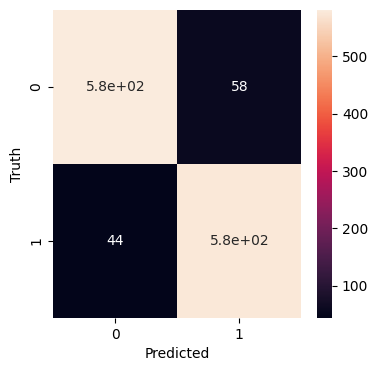

In [37]:
# Evaluate the model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predict on the test data
y_pred = model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {round(accuracy, 3)}")
print("Classification Report:")
print(report)
print("Confusion Matrix:")

# Plot the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show();

Let us remember how precision, recall and F1 score are defined:
$$\text{precision} \triangleq \frac{\text{TP}}{\text{TP}+\text{FP}}$$
$$\text{recall} \triangleq \frac{\text{TP}}{\text{TP}+\text{FN}}$$
$$F1 \triangleq 2 \cdot \frac{\text{precision}\cdot\text{recall}}{\text{precision}+\text{recall}}$$
These values are already very good. Precision and recall are also practically identical, so there is no need to try to set a threshold for special needs.

#### 2.2 Separated models
Before, we simply merged the title with the text: could this process have caused some inconsistency in the training points?\
Let us test this by separating the training, i.e. construct two classifiers: one based on titles and the other on combined texts. We cannot expect the quality of the predictions made with titles to be sufficient, so we are going to build an unbalanced "voting" system.

In [38]:
# Apply the TF-IDF Vectorizer to the title and text columns, separately
tfidf_title = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
tfidf_text = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))

X_train_title_tfidf = tfidf_title.fit_transform(X_train['title'])
X_test_title_tfidf = tfidf_title.transform(X_test['title'])

In [39]:
# Create a (probabilistic) model for the title and text columns
model1 = LogisticRegression()

# model1 is trained on title data, model2 is trained on text data
model1.fit(X_train_title_tfidf, y_train['label'])
model.fit(X_train_tfidf, y_train['label'])

LogisticRegression()

In [40]:
# Evaluate the models
y_pred_title = model1.predict(X_test_title_tfidf)
y_pred_text = model.predict(X_test_tfidf)

accuracy_title = accuracy_score(y_test, y_pred_title)
accuracy_text = accuracy_score(y_test, y_pred_text)

print(f"Accuracy for title: {round(accuracy_title, 3)}")
print(f"Accuracy for text: {round(accuracy_text, 3)}")

Accuracy for title: 0.812
Accuracy for text: 0.919


The predictive ability of model1 is lower, although it remains surprisingly close to that obtained before. Let us now add up the contributions of the two models by applying a simple weighted average, where the class probability is computed as:
$$p(C=c) = \frac{w_1\cdot p_1(c) + w_2\cdot p_2(c)}{w_1 + w_2}$$
where $w_i$ is the weight associated to model $i$ and $p_i(c)$ is the probability predicted by model $i$ for the class $c$.

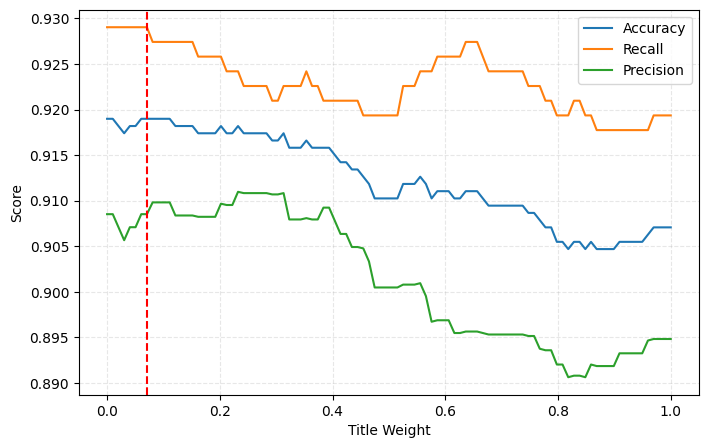

In [41]:
# Build a plot to visualize the effect of the weight on the title model
import numpy as np
from sklearn.metrics import recall_score, precision_score

# Fix the text model weight to 1
text_weight = 1.
# Get the probabilities for the title and text models
title_proba = model1.predict_proba(X_test_title_tfidf)
text_proba = model.predict_proba(X_test_tfidf)

title_weights = np.linspace(0, 1, 100)
accuracies = []
recalls = []
precisions = []
for title_weight in title_weights:
    predicted_proba = title_weight * title_proba + text_weight * text_proba
    y_pred = predicted_proba.argmax(axis=1)
    accuracies.append(accuracy_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred))

plt.figure(figsize=(8, 5))
plt.plot(title_weights, accuracies, label='Accuracy')
plt.plot(title_weights, recalls, label='Recall')
plt.plot(title_weights, precisions, label='Precision')
plt.xlabel('Title Weight')
plt.ylabel('Score')
plt.legend()
plt.grid(linestyle='--', alpha=0.3)
# Draw a line to indicate the point where accuracy and recall are maximized and precision is higher than the starting point
plt.axvline(x=0.07, color='red', linestyle='--')
plt.show();

Accuracy and Recall are dominated by the complete model, so it is basically better to choose the naive combination of titles with texts.
Only Precision has the peak for $w_t \neq 0$: this means that, albeit partially, the title analysis can better distinguish TPs from FPs.

#### 2.3 Hyperparameter Tuning
Before trying out other models, we can improve the simple Logistic Regression by setting different hyperparameter values.\
We will perform a **Grid Search** and use a pipeline to streamline the process of fitting and transforming the data. We use the following parameters:
- `tfidf_max_features` is 
- `tfidf_ngram_range = (a, b)`: we consider the n-grams from value a up to value b, 
- `logistic_c` is the inverse regularization strenght: lower values mean stronger regularization (remember the regularized loss function),
- `logistic_penalty` is the type of regularization, either `l2`, which tends to *shrink* the weights towards 0, or `l1`, which tends to *set* the weights to 0 (more strict).

The regressor's argument `max_iter` determines the maximum number of iterations to wait for convergence.

In [42]:
import os
# Import the sklearn library
from sklearn.model_selection import GridSearchCV

# Define a dictionary with the hyperparameter values: use double underscores to identify the parameters for the different models
param_grid = {
    'tfidf__max_features': [10000, 20000, 30000, 50000],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'logistic__C': [0.01, 0.1, 1, 10, 100],
    'logistic__penalty': ['l1', 'l2']
}

# Define the pipeline
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('logistic', LogisticRegression(max_iter=1000))
])

# Since the fitting process is computationally expensive, we will do it only if we do not have the results saved
if not os.path.exists('models/logreg_best_model.pkl'):
    # Initialize the GridSearchCV object, with n_jobs=-1 to use all available cores and cv to use 3-fold cross-validation
    grid_search = GridSearchCV(pipeline, param_grid, n_jobs=-1, cv=3, verbose=3)

    # Fit the GridSearchCV object on the combined data: notice that we give the combined column as input, not the vectorized data
    grid_search.fit(X_train['combined'], y_train['label'])
    logreg_best_model = grid_search.best_estimator_

    # Save the best model using joblib
    import joblib
    joblib.dump(grid_search.best_estimator_, 'models/logreg_best_model.pkl')
    
else:
    # Load the best model using joblib
    logreg_best_model = joblib.load('models/logreg_best_model.pkl')

Accuracy: 0.939
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       639
           1       0.94      0.94      0.94       620

    accuracy                           0.94      1259
   macro avg       0.94      0.94      0.94      1259
weighted avg       0.94      0.94      0.94      1259

Confusion Matrix:


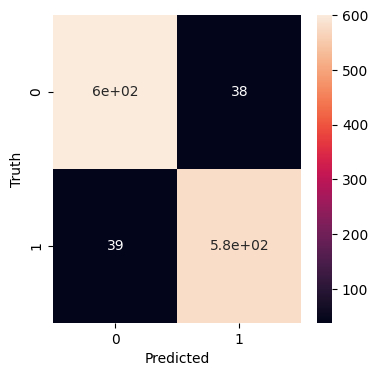

In [43]:
# Evaluate the best model
# Predict on the test data: since the best model pipeline includes the vectorizer, we should give the combined column as input
y_pred = logreg_best_model.predict(X_test['combined'])

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {round(accuracy, 3)}")
print("Classification Report:")
print(report)
print("Confusion Matrix:")

# Plot the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show();

In [44]:
# Print the best hyperparameter combination
for key in grid_search.best_params_:
    print(f'Best {key} = {grid_search.best_params_[key]}')

Best logistic__C = 100
Best logistic__penalty = l2
Best tfidf__max_features = 50000
Best tfidf__ngram_range = (1, 2)


We therefore achieved an increase of about 2 percentage points on accuracy and F1 score. We keep this model as a reference for the next section.
#### 2.4 Model Selection
Logistic Regression is certainly a model that is easy to interpret, fast and efficient even on large datasets as in this case. However, it is a linear model which, in the case of complex data as in this case, may miss some important details. Below, I list the models we are going to test and the features that might be useful here.


**SVM**: support vector machines are great to classify in spaces with many features (high dimensions) since they effectively create sets of hyperplanes in high-dimensional spaces. They can also handle quite well the *sparsity* of text data.

**Random Forest**: this is a non-linear model which, due to its ‘ensemble’ nature, manages to significantly reduce the risk of overfitting.

**Naive Bayes**: the assumption of independence between the data proves particularly effective in text classification problems, together with the excellent handling of data sparsity. This is one of the most widely used algorithms in this context, and is also quite simple in terms of implementation.

**MLP**: this simple NN is very effective in handling high-dimensional sparse data.

To achieve this comparison, we proceed to construct a new "pipeline", using different models.

In [54]:
import time
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier

# Define the model dictionary
models = {
    'svm': SVC(),
    'random_forest': RandomForestClassifier(),
    'naive_bayes': MultinomialNB(),
    'neural_network': MLPClassifier()
}

# Initialize the results dictionary
results = {}

for name, model in models.items():
    # Start the timer
    start = time.time()
    # Fit the model with the vectorized data
    model.fit(X_train_tfidf, y_train['label'])
    # Predict on the train data to find which model overfits the most
    y_pred_train = model.predict(X_train_tfidf)
    # Predict on the test data
    y_pred = model.predict(X_test_tfidf)
    # Calculate the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    # Save the results
    results[name] = {   
                    'accuracy': accuracy,
                    'train_accuracy': accuracy_score(y_train, y_pred_train),
                    'difference': accuracy - accuracy_score(y_train, y_pred_train),
                    'report': classification_report(y_test, y_pred),
                    'confusion_matrix': confusion_matrix(y_test, y_pred)
                     }
    # End the timer
    end = time.time()
    # Print the time elapsed
    print(f'Finished training {name}.\nTime = {round(end-start, 2)} seconds.\n')
    

Finished training svm.
Time = 89.16 seconds.

Finished training random_forest.
Time = 13.05 seconds.

Finished training naive_bayes.
Time = 0.04 seconds.

Finished training neural_network.
Time = 80.17 seconds.



In [56]:
# Print the results
for name in results:
    print(f"Results for {name}:")
    print(f"Accuracy: {round(results[name]['accuracy'], 3)}")
    print(f"Train Accuracy: {round(results[name]['train_accuracy'], 3)}")
    print(f"Difference: {round(results[name]['difference'], 3)}")
    print("Classification Report:")
    print(results[name]['report'])
    print("Confusion Matrix:")
    print(results[name]['confusion_matrix'])
    print()

Results for svm:
Accuracy: 0.932
Train Accuracy: 0.996
Difference: -0.065
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.92      0.93       639
           1       0.92      0.95      0.93       620

    accuracy                           0.93      1259
   macro avg       0.93      0.93      0.93      1259
weighted avg       0.93      0.93      0.93      1259

Confusion Matrix:
[[587  52]
 [ 34 586]]

Results for random_forest:
Accuracy: 0.912
Train Accuracy: 1.0
Difference: -0.088
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.92      0.91       639
           1       0.91      0.91      0.91       620

    accuracy                           0.91      1259
   macro avg       0.91      0.91      0.91      1259
weighted avg       0.91      0.91      0.91      1259

Confusion Matrix:
[[586  53]
 [ 58 562]]

Results for naive_bayes:
Accuracy: 0.895
Train Accuracy: 0.9

In [ ]:
# How much does the best logreg model overfit?
logreg_best_model.fit(X_train['combined'], y_train['label'])
y_pred_train = logreg_best_model.predict(X_train['combined'])
y_pred = logreg_best_model.predict(X_test['combined'])

train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred)

print(f'Train accuracy: {round(train_accuracy, 3)}')
print(f'Test accuracy: {round(test_accuracy, 3)}')
print(f'Difference: {round(test_accuracy - train_accuracy, 3)}')

We therefore conclude that the best model turns out to be the **Multi-Layer Perceptron**, with a result very close to the best configuration of Logistic Regression. However, the neural network is weaker in correctly identifying TPs, as shown in the confusion matrix. 

Given the very short training time for Naive Bayes, coupled with the fact that it is the model that overfills the least, it is worthwhile to perform a grid search with this model, to assess a possible improvement.\
The parameter `alpha` represents a smoothing prior, accounting for features that are not present in the learning samples and prevent zero probabilities. NB estimates the parameters $\theta_y$ with a smoothed version of MLE:
$$\hat{\theta}_{y_i} = \frac{N_{y_i}+\alpha}{N_y+\alpha n}$$ 
where $N_{y_i} = \sum_{x\in T}x_i$ is the number of times feature $i$ appears in a sample of class $y$ in the training set $T$, and $N_y = \sum^n_{i=1}N_{y_i}$ is the total count of all features for class $y$.

In [58]:
# Define a dictionary with the hyperparameter values: use double underscores to identify the parameters for the different models
param_grid = {
    'tfidf__max_features': [10000, 20000, 30000, 50000],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'nb__alpha': [0.01, 1.0, 2.0, 10.0, 100.0]
}

# Define the pipeline
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

# Since the fitting process is computationally expensive, we will do it only if we do not have the results saved
if not os.path.exists('models/nb_best_model.pkl'):
    # Initialize the GridSearchCV object, with n_jobs=-1 to use all available cores and cv to use 3-fold cross-validation
    grid_search = GridSearchCV(pipeline, param_grid, n_jobs=-1, cv=3, verbose=3)

    # Fit the GridSearchCV object on the combined data: notice that we give the combined column as input, not the vectorized data
    grid_search.fit(X_train['combined'], y_train['label'])
    nb_best_model = grid_search.best_estimator_

    # Save the best model using joblib
    import joblib
    joblib.dump(grid_search.best_estimator_, 'models/nb_best_model.pkl')
    
else:
    # Load the best model using joblib
    nb_best_model = joblib.load('models/nb_best_model.pkl')

Fitting 3 folds for each of 60 candidates, totalling 180 fits


Accuracy: 0.911
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.92      0.91       639
           1       0.92      0.90      0.91       620

    accuracy                           0.91      1259
   macro avg       0.91      0.91      0.91      1259
weighted avg       0.91      0.91      0.91      1259

Confusion Matrix:


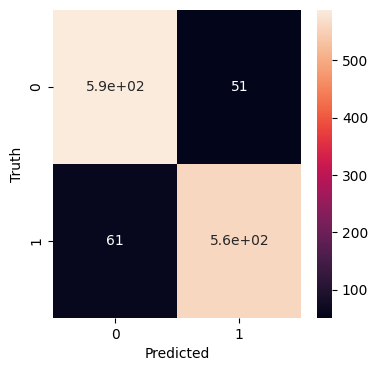

In [59]:
# Evaluate the best NB model
# Predict on the test data: since the best model pipeline includes the vectorizer, we should give the combined column as input
y_pred = nb_best_model.predict(X_test['combined'])

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {round(accuracy, 3)}")
print("Classification Report:")
print(report)
print("Confusion Matrix:")

# Plot the confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show();

We improved the performance of the Naive Bayes classifier, but it still remains below that achieved by the Logistic Regressor. Why?\
Although there are several possible explanations related to the mathematical differences between the two algorithms, in the context of fake news detection the plausible reasons are as follows:
1. NB is an extremely simple model, which may not fully capture the complexity of some of these texts. Also noteworthy is the low possibility of regularisation, from which LR draws a significant advantage.
2. NB's assumption is very strong, which is why it is very powerful with truly independent data. Instead, we know that there is a correlation between the words in the text, albeit limited. Especially in the context of news, we have noticed that there are very recurrent n-grams, an aspect that cannot be overlooked.
3. NB tends to be strongly influenced by rare data (words). In the previous notebook, we discussed the importance of recognising the most relevant words and ‘neglecting’ the contribution of rarer ones through TFIDF vectorization.

In conclusion, a classifier that is simple and quick to train is sufficient for this project: **Logistic Regression**.